GROUNDING DINO PORTION

In [79]:
import torch
import cv2
import numpy as np
from torchvision.ops import box_convert
import matplotlib.pyplot as plt

In [80]:
#Grounding-DINO weights and config file
GROUNDING_DINO_CHECKPOINT_PATH = (r"C:\Users\alpho\Downloads\GroundingDINO-main\GroundingDINO-main\groundingdino_swint_ogc.pth")
GROUNDING_DINO_CONFIG_PATH=(r"C:\Users\alpho\Downloads\GroundingDINO-main\GroundingDINO-main\config\GroundingDINO_SwinT_OGC.py")

#Segment Anything-weights and config file
SAM_CHECKPOINT_PATH = (r"C:\Users\alpho\Downloads\segment-anything-main\segment-anything-main\sam_vit_h_4b8939.pth")
SAM_CONFIG_PATH=(r"C:\Users\alpho\Downloads\segment-anything-main\segment-anything-main\demo\configs\webpack\prod.js")

In [81]:
from transformers import utils  # Correct import
from groundingdino.util.inference import Model, load_model, load_image, predict, annotate

model = load_model(GROUNDING_DINO_CONFIG_PATH, GROUNDING_DINO_CHECKPOINT_PATH,device='cpu')
#grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,device="mps")

final text_encoder_type: bert-base-uncased


In [82]:
# Load image and define image_source
IMAGE_PATH = r"C:\Users\alpho\OneDrive\CSCI 436_490\Final_Project\lions.jpg"
image_source, image = load_image(IMAGE_PATH)

TEXT_PROMPT = "eye"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)


tensor([[0.7034, 0.3209, 0.0398, 0.0555],
        [0.7986, 0.3288, 0.0310, 0.0403],
        [0.3303, 0.3043, 0.0340, 0.0493],
        [0.4227, 0.3243, 0.0276, 0.0488]])
tensor([0.6314, 0.6169, 0.6457, 0.6030])
['eye', 'eye', 'eye', 'eye']


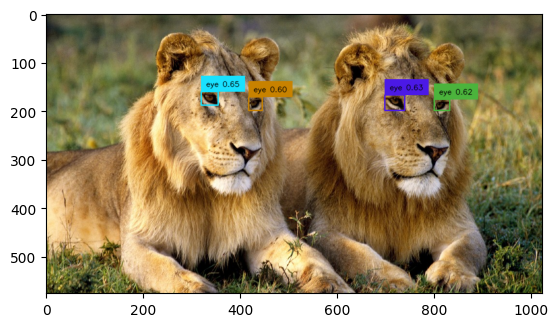

In [83]:
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device='cpu'
)

annotated_frame = annotate(image_source=cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB), boxes=boxes, logits=logits, phrases=phrases)
# cv2.imwrite("annotated_image.jpg", annotated_frame)
print(boxes)
print(logits)
print(phrases)

plt.imshow(annotated_frame)

SAM PORTION

In [84]:
from segment_anything import sam_model_registry, SamPredictor,SamAutomaticMaskGenerator

In [85]:
def show_mask(mask, ax, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [86]:
sam_checkpoint = r"C:\Users\alpho\Downloads\segment-anything-main\segment-anything-main\sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
# sam.to(dtype=torch.float32)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

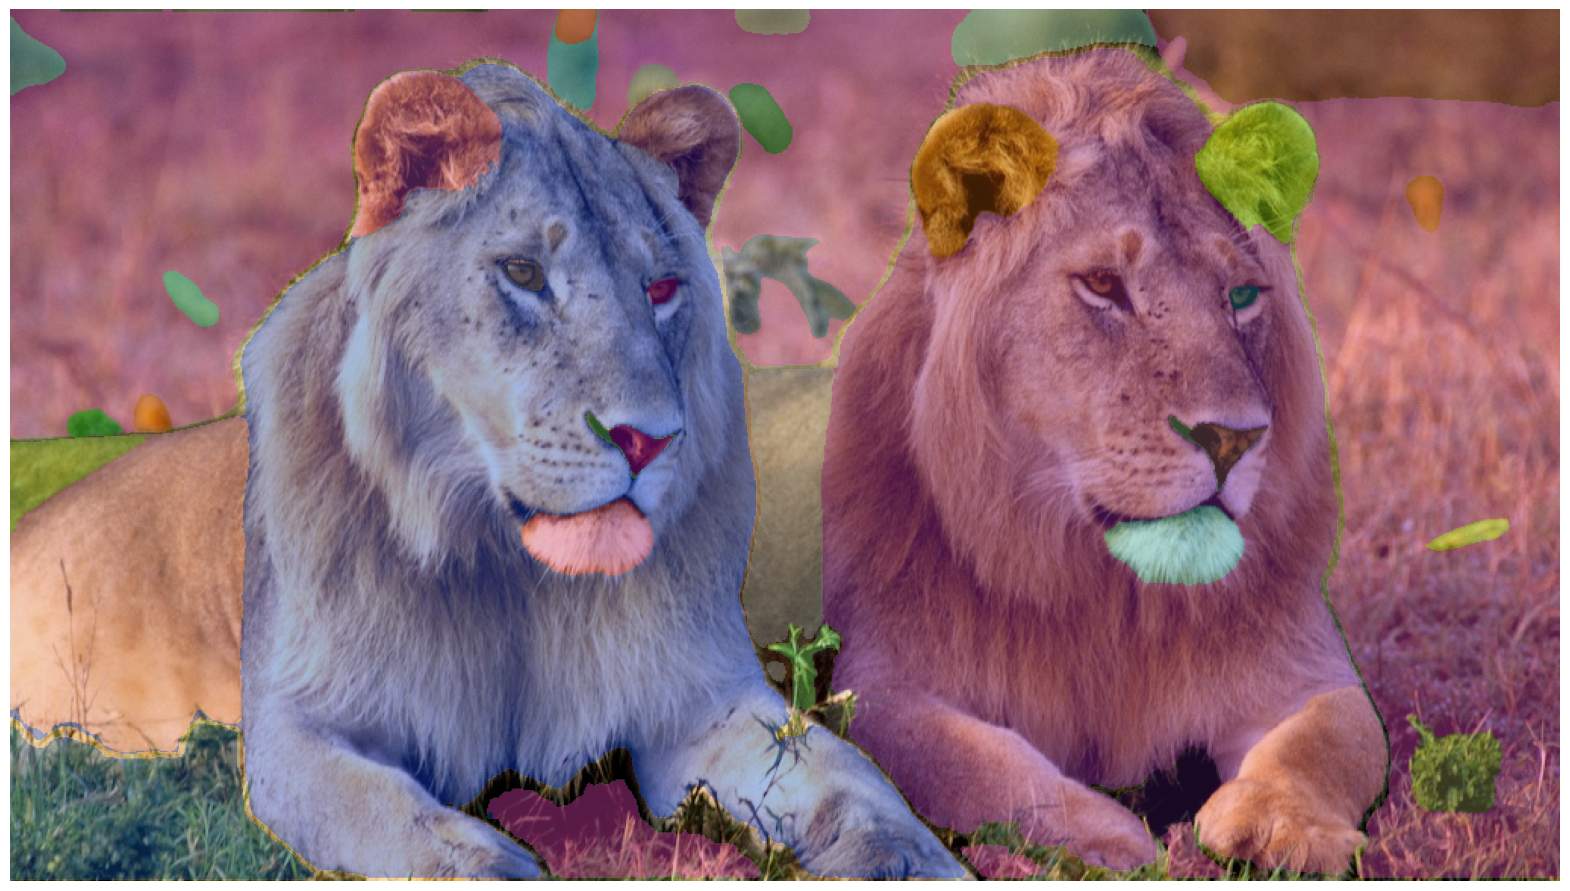

CPU times: total: 11min 39s
Wall time: 4min 26s


In [87]:
%%time
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image_source)

plt.figure(figsize=(20,20))
plt.imshow(image_source)
show_anns(masks)
plt.axis('off')
plt.show()

In [88]:
%%time
predictor = SamPredictor(sam)
predictor.set_image(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))

CPU times: total: 3min 15s
Wall time: 1min 20s


In [89]:
h, w, _ = image_source.shape
print(h,w)
print(boxes)
boxes_converted = boxes * torch.Tensor([w, h, w, h])
xyxy = box_convert(boxes=boxes_converted, in_fmt="cxcywh", out_fmt="xyxy")
print(xyxy)
# input_box = np.array(boxes[0])
# input_box=np.floor(input_box*[image.size()[1],image.size()[2],image.size()[1],image.size()[2]])
# input_box
input_box=np.floor(np.array(xyxy[1]))
print(input_box)

576 1024
tensor([[0.7034, 0.3209, 0.0398, 0.0555],
        [0.7986, 0.3288, 0.0310, 0.0403],
        [0.3303, 0.3043, 0.0340, 0.0493],
        [0.4227, 0.3243, 0.0276, 0.0488]])
tensor([[699.9002, 168.8378, 740.6743, 200.7955],
        [801.8705, 177.7575, 833.6320, 200.9920],
        [320.8233, 161.1091, 355.6298, 189.4825],
        [418.7319, 172.7632, 446.9437, 200.8751]])
[801. 177. 833. 200.]


In [90]:
# Continue with the rest of your code using input_box
masks, _, _ = predictor.predict(
    box=input_box,
    multimask_output=True,
)

print(masks.shape)

(3, 576, 1024)


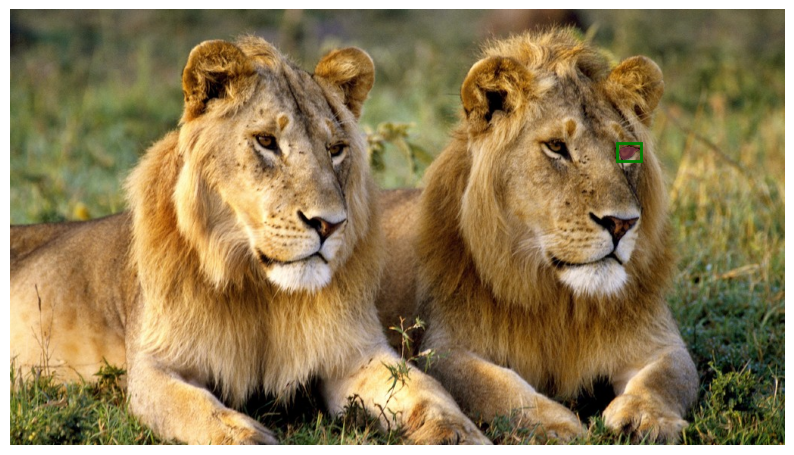

In [91]:
plt.figure(figsize=(10, 10))
plt.imshow(image_source)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

SPEECH TO TEXT PORTION (Only records and save to file)

In [92]:
import io
import os
import wave
import pyaudio
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor,SamAutomaticMaskGenerator
from google.cloud import speech_v1p1beta1 as speech
#Import API credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\alpho\Downloads\GroundingDINO-main\GroundingDINO-main\API_Key_for_speech_to_text.json"

def record_audio(filename, duration=5):
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    frames = []
#notify user that system has started recording and Record

    print("Recording...")
    for i in range(0, int(RATE / CHUNK * duration)):
        data = stream.read(CHUNK)
        frames.append(data)
#notify user that system has stoped recording and terminate
    print("Finished recording.")
    stream.stop_stream()
    stream.close()
    p.terminate()
#Redirecting...store/save the recording in file "temp_audio.wav"
    wf = wave.open(filename, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(pyaudio.PyAudio().get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()


USE  Grounding dino + Google speech API to segment in SAM

In [93]:
import torch
import cv2
import numpy as np
from torchvision.ops import box_convert
import matplotlib.pyplot as plt

from transformers import utils
from groundingdino.util.inference import Model, load_model, load_image, predict, annotate

# Grounding-DINO weights and config file & Load or create the Grounding DINO model
GROUNDING_DINO_CHECKPOINT_PATH = r"C:\Users\alpho\Downloads\GroundingDINO-main\GroundingDINO-main\groundingdino_swint_ogc.pth"
GROUNDING_DINO_CONFIG_PATH = r"C:\Users\alpho\Downloads\GroundingDINO-main\GroundingDINO-main\config\GroundingDINO_SwinT_OGC.py"
model = load_model(GROUNDING_DINO_CONFIG_PATH, GROUNDING_DINO_CHECKPOINT_PATH,device='cpu')
# Segment Anything weights and config file & Load or create the SAM model
SAM_CHECKPOINT_PATH = r"C:\Users\alpho\Downloads\segment-anything-main\segment-anything-main\sam_vit_h_4b8939.pth"
SAM_CONFIG_PATH = r"C:\Users\alpho\Downloads\segment-anything-main\segment-anything-main\demo\configs\webpack\prod.js"
#model = load_model(SAM_CONFIG_PATH, SAM_CHECKPOINT_PATH,device='cpu')
# Load image and define image_source
IMAGE_PATH = r"C:\Users\alpho\OneDrive\CSCI 436_490\Final_Project\front-of-house-close-up.jpg"
image_source, image = load_image(IMAGE_PATH)

# List of trained datasets
trained_datasets = ["", "windows"]  # Add more datasets as needed, use an empty string as a placeholder

# Define boxes outside the loop
boxes = None
#masks = None  #note for me to use only when I want mask function to mask out descriptor array

final text_encoder_type: bert-base-uncased


Function to extract voice and Transcribe audio  for segmenting,annotating and masking

Recording...
Finished recording.
Transcript: cut ground
Output for keyword '':
tensor([[0.4999, 0.8669, 0.9965, 0.2615],
        [0.2054, 0.8542, 0.4094, 0.1765]])
tensor([0.4658, 0.3549])
['ground', 'ground']


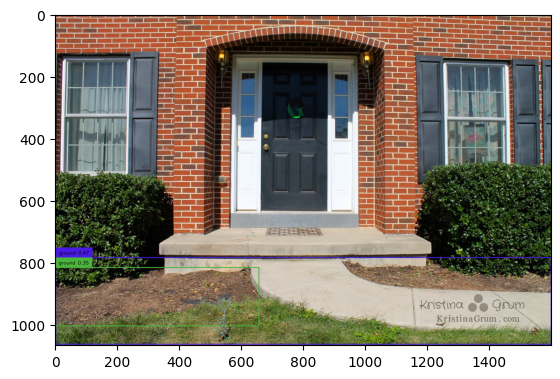

1066 1600
tensor([[0.4999, 0.8669, 0.9965, 0.2615],
        [0.2054, 0.8542, 0.4094, 0.1765]])
tensor([[2.7088e+00, 7.8467e+02, 1.5971e+03, 1.0635e+03],
        [1.2172e+00, 8.1649e+02, 6.5622e+02, 1.0047e+03]])
[   2.  784. 1597. 1063.]
(3, 1066, 1600)


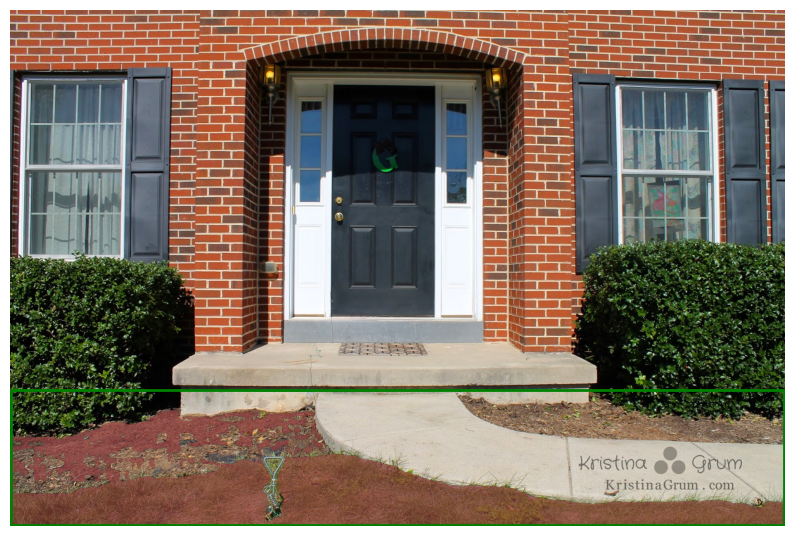

Output for keyword 'windows':
tensor([[0.8463, 0.3012, 0.1295, 0.3177],
        [0.1059, 0.3023, 0.2035, 0.3804],
        [0.4820, 0.3743, 0.2589, 0.5139],
        [0.0815, 0.3034, 0.1397, 0.3626],
        [0.8234, 0.3181, 0.1923, 0.3913]])
tensor([0.5070, 0.4509, 0.4299, 0.4051, 0.3537])
['windows', 'windows', 'windows', 'windows', 'windows']


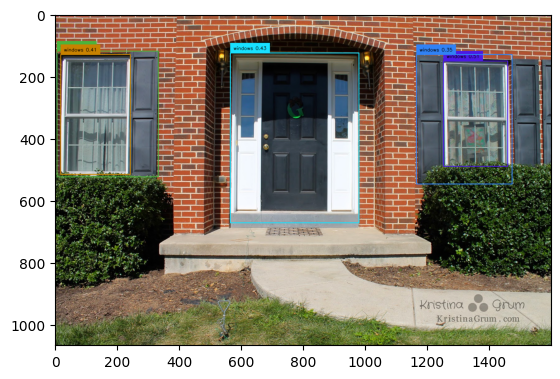

1066 1600
tensor([[0.8463, 0.3012, 0.1295, 0.3177],
        [0.1059, 0.3023, 0.2035, 0.3804],
        [0.4820, 0.3743, 0.2589, 0.5139],
        [0.0815, 0.3034, 0.1397, 0.3626],
        [0.8234, 0.3181, 0.1923, 0.3913]])
tensor([[1250.5486,  151.7495, 1457.7446,  490.3857],
        [   6.6276,  119.4943,  332.2107,  524.9880],
        [ 564.1122,  125.1317,  978.4129,  672.9736],
        [  18.6194,  130.1817,  242.2180,  516.7065],
        [1163.6670,  130.5060, 1471.2690,  547.6398]])
[1250.  151. 1457.  490.]
(3, 1066, 1600)


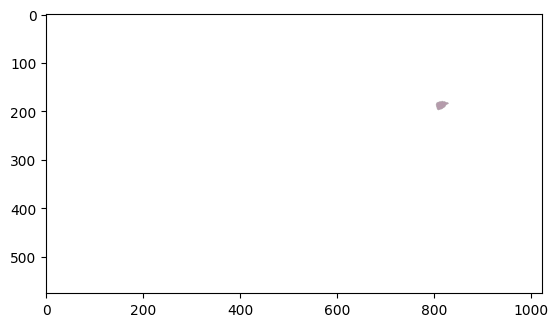

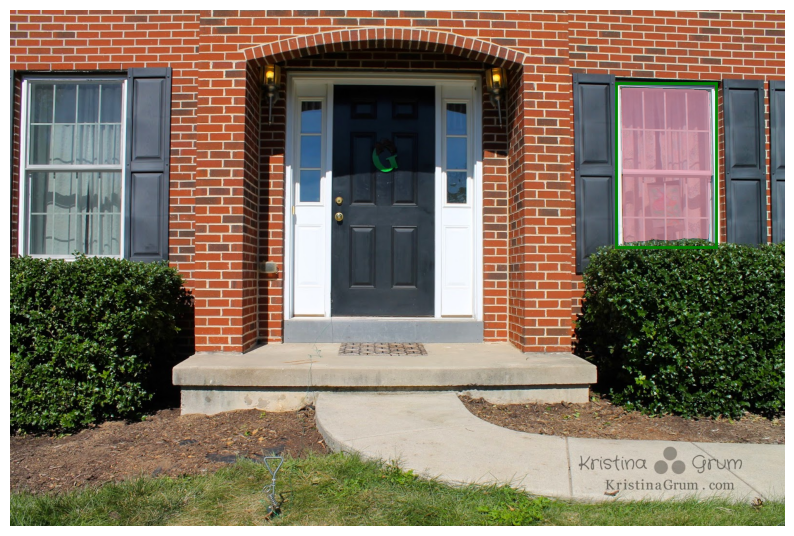

In [95]:
for TEXT_PROMPT in trained_datasets:
    BOX_THRESHOLD = 0.35  # Adjust as needed
    TEXT_THRESHOLD = 0.25  # Adjust as needed

    # Skip Grounding Dino prediction for empty string placeholder
    if not TEXT_PROMPT:
        # Function to perform speech-to-text
        def transcribe_and_segment_audio():
            # Record audio from the microphone
            audio_file_path = "temp_audio.wav"
            record_audio(audio_file_path)

            # Transcribe audio using Google Speech-to-Text
            client = speech.SpeechClient()

            with io.open(audio_file_path, "rb") as audio_file:
                content = audio_file.read()

            audio = speech.RecognitionAudio(content=content)
            config = speech.RecognitionConfig(
                encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
                sample_rate_hertz=16000,
                language_code="en-US",
            )

            response = client.recognize(config=config, audio=audio)

            # Extract the transcribed text
            transcribed_text = ""
            for result in response.results:
                print("Transcript: {}".format(result.alternatives[0].transcript))
                transcribed_text += result.alternatives[0].transcript.lower()

            # Check if the word "cut" is present in the transcribed text
            if "cut" not in transcribed_text:
                print("Error: The word 'cut' is missing in the provided text.")
                return

            # Extract keywords after the "cut" keyword
            keywords = transcribed_text.split("cut")[1].strip().split(" and ")

            if not keywords:
                print("Error: Please provide at least one keyword after 'cut'.")
                return

            # Use the first extracted keyword for segmentation
            keyword = keywords[0]

            # Use the transcribed keyword as the caption for Grounding Dino
            boxes, logits, phrases = predict(
                model=model,
                image=image,
                caption=keyword,
                box_threshold=BOX_THRESHOLD,
                text_threshold=TEXT_THRESHOLD,
                device='cpu'
            )
            #Use grounding dino to annotate and show the boxed area
            annotated_frame = annotate(image_source=cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB), boxes=boxes, logits=logits, phrases=phrases)
            print(f"Output for keyword '{TEXT_PROMPT}':")
            print(boxes)
            print(logits)
            print(phrases)
            #mask_generator = SamAutomaticMaskGenerator(sam)
            #masks = mask_generator.generate(image_source)
            plt.imshow(annotated_frame)   #show frames with lables
            plt.show()                    #show the image ma
            #show_mask(masks[0], plt.gca())  #segment out the annoted area

            # Continue with SAM portion (uncommented)
            predictor = SamPredictor(sam)
            predictor.set_image(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))

            h, w, _ = image_source.shape
            print(h, w)
            print(boxes)

            # Check if there are any bounding boxes detected
            if boxes.size(0) == 0:
                print("No bounding boxes detected.")
            else:
                boxes_converted = boxes * torch.Tensor([w, h, w, h])
                xyxy = box_convert(boxes=boxes_converted, in_fmt="cxcywh", out_fmt="xyxy")
                print(xyxy)

                # Assuming we want the first box if there are multiple boxes
                input_box = np.floor(np.array(xyxy[0]))
                print(input_box)

                # Continue with SAM predictor
                masks, _, _ = predictor.predict(
                    box=input_box,
                    multimask_output=True,
                )

                print(masks.shape)

                plt.figure(figsize=(10, 10))
                plt.imshow(image_source)
                show_mask(masks[0], plt.gca())
                show_box(input_box, plt.gca())
                plt.axis('off')
                plt.show()

            # Clean up temporary audio file
            os.remove(audio_file_path)

        # Call the function to transcribe audio and segment the image
        transcribe_and_segment_audio()

    else:
        # Use the transcribed text as the caption for Grounding Dino
        boxes, logits, phrases = predict(
            model=model,
            image=image,
            caption=TEXT_PROMPT,
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD,
            device='cpu'
        )

        #Use grounding dino to annotate and show the boxed area
        annotated_frame = annotate(image_source=cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB), boxes=boxes, logits=logits, phrases=phrases)
        print(f"Output for keyword '{TEXT_PROMPT}':")
        print(boxes)
        print(logits)
        print(phrases)

        plt.imshow(annotated_frame)   #show frames with lables
        plt.show()
        show_mask(masks[0], plt.gca())

        # Continue with SAM portion 
        predictor = SamPredictor(sam)
        predictor.set_image(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))

        h, w, _ = image_source.shape
        print(h, w)
        print(boxes)

        # Check if there are any bounding boxes detected
        if boxes.size(0) == 0:
            print("No bounding boxes detected.")
        else:
            boxes_converted = boxes * torch.Tensor([w, h, w, h])
            xyxy = box_convert(boxes=boxes_converted, in_fmt="cxcywh", out_fmt="xyxy")
            print(xyxy)

            # Assuming you want the first box if there are multiple boxes
            input_box = np.floor(np.array(xyxy[0]))
            print(input_box)

            # Continue with SAM predictor
            masks, _, _ = predictor.predict(
                box=input_box,
                multimask_output=True,
            )

            print(masks.shape)

            plt.figure(figsize=(10, 10))
            plt.imshow(image_source)  
            show_mask(masks[0], plt.gca())
            show_box(input_box, plt.gca())
            plt.axis('off')
            plt.show()

Function to extract voice and Transcribe audio  for segmenting

1066 1600
tensor([[0.4816, 0.3708, 0.1362, 0.4500]])
tensor([[661.5633, 155.4516, 879.5357, 635.1381]])
[661. 155. 879. 635.]
(3, 1066, 1600)


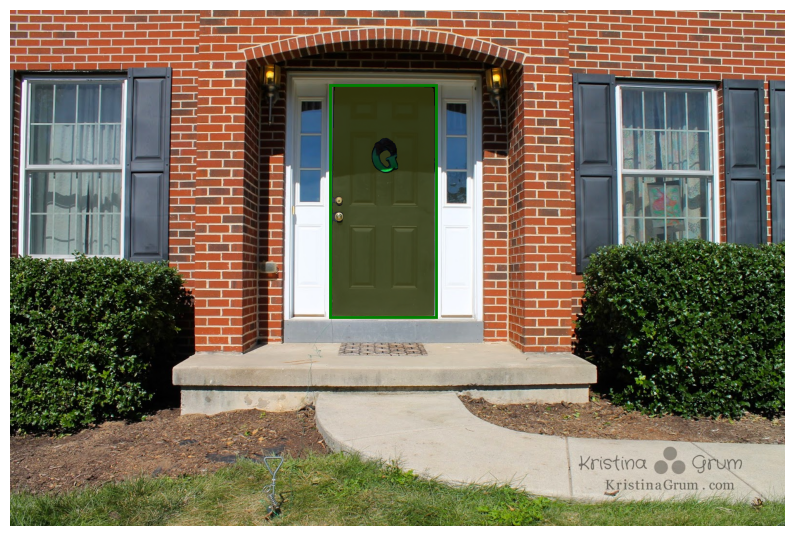

1066 1600
tensor([[0.5001, 0.9246, 0.9970, 0.1480]])
tensor([[   2.6766,  906.7195, 1597.8022, 1064.5088]])
[   2.  906. 1597. 1064.]
(3, 1066, 1600)


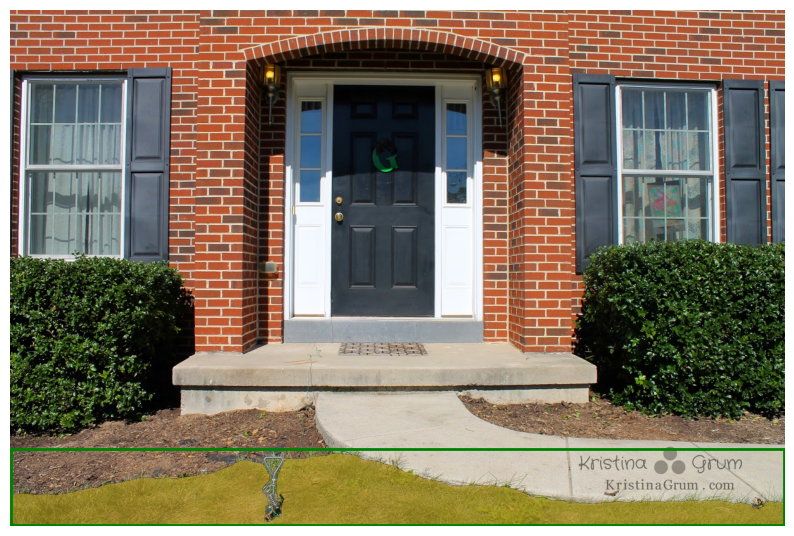

1066 1600
tensor([], size=(0, 4))
No bounding boxes detected.


In [ ]:
for TEXT_PROMPT in trained_datasets:
    BOX_THRESHOLD = 0.35  # Adjust as needed
    TEXT_THRESHOLD = 0.25  # Adjust as needed

    # Skip Grounding Dino prediction for empty string placeholder
    if not TEXT_PROMPT:
        # Function to perform speech-to-text
        def transcribe_and_segment_audio():
            # Record audio from the microphone
            audio_file_path = "temp_audio.wav"
            record_audio(audio_file_path)

            # Transcribe audio using Google Speech-to-Text
            client = speech.SpeechClient()

            with io.open(audio_file_path, "rb") as audio_file:
                content = audio_file.read()

            audio = speech.RecognitionAudio(content=content)
            config = speech.RecognitionConfig(
                encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
                sample_rate_hertz=16000,
                language_code="en-US",
            )

            response = client.recognize(config=config, audio=audio)

            # Extract the transcribed text
            transcribed_text = ""
            for result in response.results:
                print("Transcript: {}".format(result.alternatives[0].transcript))
                transcribed_text += result.alternatives[0].transcript.lower()

            # Check if the word "cut" is present in the transcribed text
            if "cut" not in transcribed_text:
                print("Error: The word 'cut' is missing in the provided text.")
                return

            # Extract keywords after the "cut" keyword
            keywords = transcribed_text.split("cut")[1].strip().split(" and ")

            if not keywords:
                print("Error: Please provide at least one keyword after 'cut'.")
                return

            # Use the first extracted keyword for segmentation
            keyword = keywords[0]

            # Use the transcribed keyword as the caption for Grounding Dino
            boxes, logits, phrases = predict(
                model=model,
                image=image,
                caption=keyword,
                box_threshold=BOX_THRESHOLD,
                text_threshold=TEXT_THRESHOLD,
                device='cpu'
            )

            # ... (rest of your code for Grounding Dino)

            # Continue with SAM portion (uncommented)
            predictor = SamPredictor(sam)
            predictor.set_image(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))

            h, w, _ = image_source.shape
            print(h, w)
            print(boxes)

            # Check if there are any bounding boxes detected
            if boxes.size(0) == 0:
                print("No bounding boxes detected.")
            else:
                boxes_converted = boxes * torch.Tensor([w, h, w, h])
                xyxy = box_convert(boxes=boxes_converted, in_fmt="cxcywh", out_fmt="xyxy")
                print(xyxy)

                # Assuming you want the first box if there are multiple boxes
                input_box = np.floor(np.array(xyxy[0]))
                print(input_box)

                # Continue with SAM predictor
                masks, _, _ = predictor.predict(
                    box=input_box,
                    multimask_output=True,
                )

                print(masks.shape)

                plt.figure(figsize=(10, 10))
                plt.imshow(image_source)
                show_mask(masks[0], plt.gca())
                show_box(input_box, plt.gca())
                plt.axis('off')
                plt.show()

            # Clean up temporary audio file
            os.remove(audio_file_path)

        # Call the function to transcribe audio and segment the image
        transcribe_and_segment_audio()

    else:
        # Use the transcribed text as the caption for Grounding Dino
        boxes, logits, phrases = predict(
            model=model,
            image=image,
            caption=TEXT_PROMPT,
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD,
            device='cpu'
        )

        # ... (rest of your code for Grounding Dino)

        # Continue with SAM portion (uncommented)
        predictor = SamPredictor(sam)
        predictor.set_image(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))

        h, w, _ = image_source.shape
        print(h, w)
        print(boxes)

        # Check if there are any bounding boxes detected
        if boxes.size(0) == 0:
            print("No bounding boxes detected.")
        else:
            boxes_converted = boxes * torch.Tensor([w, h, w, h])
            xyxy = box_convert(boxes=boxes_converted, in_fmt="cxcywh", out_fmt="xyxy")
            print(xyxy)

            # Assuming you want the first box if there are multiple boxes
            input_box = np.floor(np.array(xyxy[0]))
            print(input_box)

            # Continue with SAM predictor
            masks, _, _ = predictor.predict(
                box=input_box,
                multimask_output=True,
            )

            print(masks.shape)

            plt.figure(figsize=(10, 10))
            plt.imshow(image_source)
            show_mask(masks[0], plt.gca())
            show_box(input_box, plt.gca())
            plt.axis('off')
            plt.show()